In [1]:
%env CUDA_VISIBLE_DEVICES=-1
import pylab as plt
plt.style.use('dark_background')
import torch
import torch.nn.functional as F
from tqdm import tqdm

env: CUDA_VISIBLE_DEVICES=-1


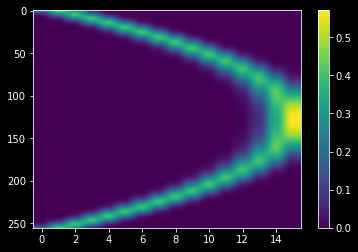

In [2]:
_theta = torch.vstack([
    (-0.5 * (torch.arange(-8, 8) - 14 * ((128**2 - (i-128)**2) / 128**2 - 0.5)).square()).view(1,-1).softmax(-1)
    for i in range(256)
])
plt.imshow(_theta, aspect='auto')
plt.colorbar()
plt.show()

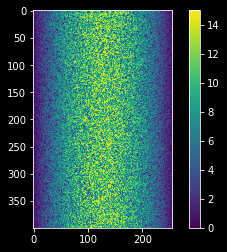

In [3]:
_theta = torch.vstack([
    (-0.5 * (torch.arange(-8, 8) - 14 * ((128**2 - (i-128)**2) / 128**2 - 0.5)).square()).view(1,-1).softmax(-1)
    for i in range(256)
])
theta = _theta.repeat(400, 1, 1)
u = torch.rand(400, 256, 16)
b = (theta > u).float()
plt.imshow(b.argmax(-1))
plt.colorbar()
plt.show()

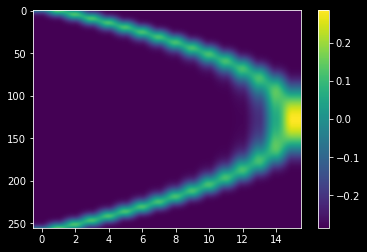

In [4]:
plt.imshow(_theta - (_theta.max() - _theta.min()) / 2, aspect='auto')
plt.colorbar()
plt.show()

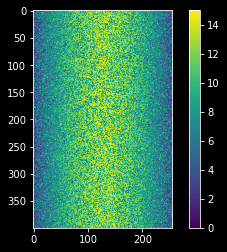

In [5]:
theta = _theta.repeat(400, 1, 1)
z = torch.zeros_like(theta)
z = F.gumbel_softmax(logits=-(1 / (theta + 1e-1) - 1).log(), tau=1, hard=True)
# z = F.gumbel_softmax(logits=-(1 / (theta + (theta.max() - theta.min()) / 2) - 1).log(), tau=1, hard=True)
# z = F.gumbel_softmax(logits=theta - (theta.max() - theta.min()) / 2, tau=1, hard=True)
plt.imshow(z.argmax(-1))
plt.colorbar()
plt.show()

In [6]:
def norm_alpha(p, alpha):
    pnorm = p.norm(p=1) / p.shape[0]
    if pnorm >= alpha:
        return alpha / pnorm * p
    else:
        return 1 - (1 - alpha) / (1 - pnorm) * (1 - p)

In [7]:
_theta = torch.cat([torch.linspace(0.01, 0.9, 128), torch.linspace(0.9, 0.01, 128)])
print((_theta > 0.5).float().norm(p=0))
print((norm_alpha(_theta, 0.3) > 0.5).float().norm(p=0))

tensor(116.)
tensor(42.)


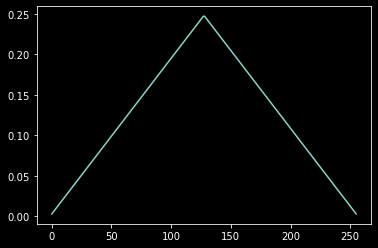

In [8]:
plt.plot(norm_alpha(_theta, 0.125))

# REINFORCE

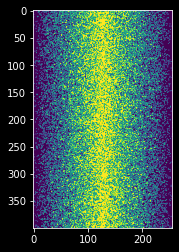

tensor(0.1867)


In [9]:
# f = lambda x : x[:, :128].norm(p=2) - x[:, 128:].norm(p=2)
f = lambda x : x[:, ::2].norm(p=2) - x[:, 1::2].norm(p=2)

_theta = torch.cat([torch.linspace(0.01, 0.9, 128), torch.linspace(0.9, 0.01, 128)])
theta = _theta.repeat(400, 1)
u = torch.rand(400, 256)
b = (u < theta).float()
plt.imshow(b)
plt.show()
print(f(b))

In [10]:
_theta = torch.nn.Parameter(data=_theta)
optimizer = torch.optim.Adam([_theta], lr=1e-2)

pbar = tqdm(range(100))
for i in pbar:
    theta = _theta.repeat(400, 1)
    u = torch.rand(400, 256)
    b = (u < theta).float()
    b.requires_grad = True
    bg = torch.autograd.grad(f(b), b)[0].mean(0)
    optimizer.zero_grad()
    _theta.grad = bg / (_theta + 1e-11)
    optimizer.step()
    _theta.data.clip_(1e-3, 1 - 1e-3)
    pbar.set_description(f'loss: {f(b).item()}')

loss: -218.62954711914062: 100%|██████████| 100/100 [00:00<00:00, 232.79it/s]


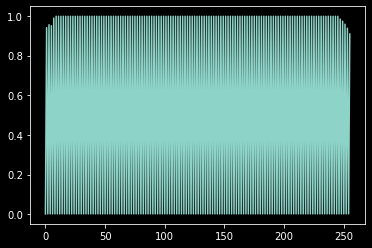

In [4]:
plt.plot(_theta.detach())

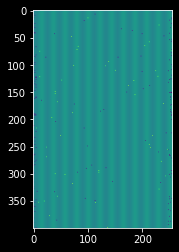

tensor(-218.8429)


In [5]:
theta = _theta.repeat(400, 1).detach()
u = torch.rand(400, 256)
b = (u < theta).float()
plt.imshow(b)
plt.show()
print(f(b))

# Reparametrization

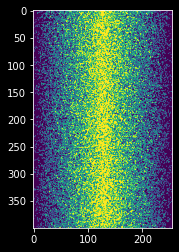

tensor(0.1508)


In [7]:
H = lambda x : (x > 0.5).float()
# f = lambda x : x[:, :128].norm(p=2) - x[:, 128:].norm(p=2)
f = lambda x : x[:, ::2].norm(p=2) - x[:, 1::2].norm(p=2)


_theta = torch.cat([torch.linspace(0.01, 0.9, 128), torch.linspace(0.9, 0.01, 128)])
theta = _theta.repeat(400, 1)
u = torch.rand(400, 256)
z = ((u.log() - (-u).log1p() + theta.log() - (-theta).log1p()) / 0.05).sigmoid()
plt.imshow(H(z))
plt.show()
print(f(H(z)))

In [8]:
_theta = torch.nn.Parameter(data=_theta)

optimizer = torch.optim.Adam([_theta], lr=1e-2)

pbar = tqdm(range(100))
for i in pbar:
    theta = _theta.repeat(400, 1)
    u = torch.rand(400, 256)
    z = ((u.log() - (-u).log1p() + theta.log() - (-theta).log1p()) / 0.05).sigmoid()
    loss = f(z)
    optimizer.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(_theta, 1.0)
    optimizer.step()
    _theta.data.clip_(1e-3, 1 - 1e-3)
    pbar.set_description(f'loss: {loss.item()}')

loss: -218.75439453125: 100%|██████████| 100/100 [00:00<00:00, 238.17it/s]


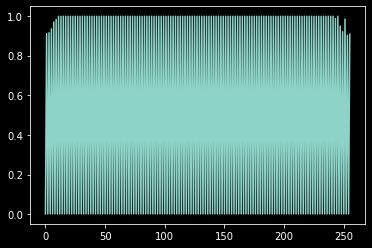

In [9]:
plt.plot(_theta.detach())

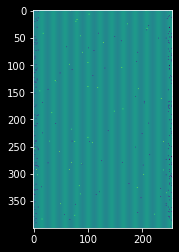

tensor(-218.7613)


In [10]:
theta = _theta.repeat(400, 1).detach()
u = torch.rand(400, 256)
z = ((u.log() - (-u).log1p() + theta.log() - (-theta).log1p()) / 0.05).sigmoid()
plt.imshow(H(z))
plt.show()
print(f(H(z)))

# RELAX

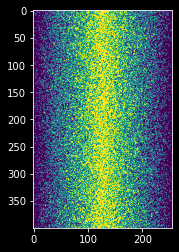

tensor(1.2136)


In [184]:
H = lambda x : (x > 0.0).float()
f = lambda x : x[:, 64:-64].mean() - x[:, :64].mean() - x[:, -64:].mean() + 1


_theta = torch.cat([torch.linspace(0.01, 0.9, 128), torch.linspace(0.9, 0.01, 128)])
theta = _theta.repeat(400, 1)

u = torch.rand(400, 256)
z = (theta / (1 - theta)).log() + (u / (1 - u)).log()

plt.imshow(H(z))
plt.show()
print(f(H(z)))

In [185]:
c = torch.nn.Sequential(
    torch.nn.Linear(256, 256, bias=False),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 256, bias=False),
)

_theta = torch.nn.Parameter(data=_theta)

optim_c = torch.optim.AdamW(c.parameters(), lr=1e-2)
optim_t = torch.optim.Adam([_theta], lr=1e-2)

pbar = tqdm(range(100))
for i in pbar:
    theta = _theta.repeat(400, 1)
    # sample uniform noise
    u = torch.rand(400, 256)
    v = torch.rand(400, 256)
    # z ~ p(z|theta)
    z = (theta / (1 - theta + 1e-11)).log() + (u / (1 - u + 1e-11)).log()
    # z_tilda ~ p(z|b,theta)
    v_tilda = torch.zeros_like(u)
    v_tilda[H(z) == 0] = v[H(z) == 0] * (1 - theta[H(z) == 0])
    v_tilda[H(z) == 1] = v[H(z) == 1] * theta[H(z) == 1] + (1 - theta[H(z) == 1])
    z_tilda = (theta / (1 - theta + 1e-11)).log() + (v_tilda / (1 - v_tilda + 1e-11)).log()
    # dc/dz
    g_c_z_theta = torch.autograd.grad(c(z).mean(0), _theta, torch.ones_like(_theta))[0]
    # dc/dz_tilda
    g_c_z_tilda_theta = torch.autograd.grad(c(z_tilda).mean(0), _theta, torch.ones_like(_theta))[0]
    # df/dtheta
    b = H(z)
    b.requires_grad = True
    bf = torch.autograd.grad(f(b), b)[0].mean(0)
    g_theta = (bf - c(z_tilda).mean(0)) / (_theta + 1e-11) + g_c_z_theta - g_c_z_tilda_theta
    # d(df/dtheta)/dphi
    g_phi = torch.autograd.grad(g_theta.square().mean(), c.parameters())
    optim_t.zero_grad()
    optim_c.zero_grad()
    _theta.grad = torch.nan_to_num(g_theta.data.clone(), 0.)
    for p, g in zip(c.parameters(), g_phi):
        p.grad = torch.nan_to_num(g.data.clone(), 0.)
    optim_c.step()
    optim_t.step()
    _theta.data.clip_(1e-3, 1 - 1e-3)
    pbar.set_description(f'loss: {f(H(z)).item()}')

loss: 1.228515625: 100%|██████████| 100/100 [00:01<00:00, 51.62it/s]


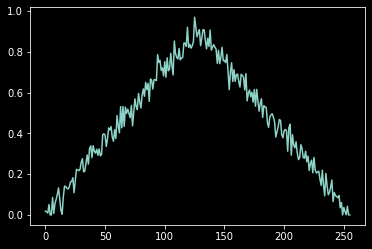

In [183]:
plt.plot(_theta.detach())

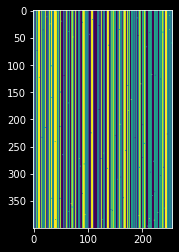

tensor(0.3988)


In [162]:
theta = _theta.repeat(400, 1).detach()
u = torch.rand(400, 256)
z = (theta / (1 - theta + 1e-11)).log() + (u / (1 - u + 1e-11)).log()
plt.imshow(H(z))
plt.show()
print(f(H(z)))